In [ ]:

# Produced by: Kirubel Temesgen
# College ID: C00260396
# Description: This is a Kmeans Clustering model implementation for email spam detection.

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.sparse import hstack

# Load dataset
file_path = r"D:\college\Sem2\DataSci ML\archive\emails.csv"
df = pd.read_csv(file_path).sample(frac=0.1, random_state=42)  # Use 10% of data for efficiency

# Extract email components
def extract_email_components(email):
    from_match = re.search(r'From: (.+)', email)
    subject_match = re.search(r'Subject: (.*)', email)
    body_match = re.search(r'\n\n(.*)', email, re.DOTALL)  # Extract body after blank line

    return {
        "From": from_match.group(1).strip() if from_match else None,
        "Subject": subject_match.group(1).strip() if subject_match else None,
        "Body": body_match.group(1).strip() if body_match else None
    }

# Apply function to extract fields
email_components = df['message'].apply(extract_email_components)
email_df = pd.DataFrame(email_components.tolist())

# Merge extracted data with original DataFrame
df = pd.concat([df, email_df], axis=1)

# Drop unnecessary columns
df = df.drop(columns=["message", "file"], errors="ignore")

# Drop rows with missing values in key fields
df = df.dropna(subset=["From", "Subject", "Body"])



In [12]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 51740 entries, 49003 to 51739
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   From                51740 non-null  object
 1   Processed_Subject   51740 non-null  object
 2   Processed_Body      51740 non-null  object
 3   Spam_Words_Subject  51740 non-null  int64 
 4   Spam_Words_Body     51740 non-null  int64 
 5   Is_External_Sender  51740 non-null  int64 
 6   Is_Business_Report  51740 non-null  bool  
 7   Cluster_Label       51740 non-null  int32 
dtypes: bool(1), int32(1), int64(3), object(3)
memory usage: 3.0+ MB


(None,
        Spam_Words_Subject  Spam_Words_Body  Is_External_Sender  Cluster_Label
 count        51740.000000     51740.000000        51740.000000   51740.000000
 mean             0.019057         0.501797            0.176208       0.630267
 std              0.140216         0.884187            0.381001       0.908575
 min              0.000000         0.000000            0.000000       0.000000
 25%              0.000000         0.000000            0.000000       0.000000
 50%              0.000000         0.000000            0.000000       0.000000
 75%              0.000000         1.000000            0.000000       2.000000
 max              2.000000         8.000000            1.000000       2.000000)

In [4]:
# Function to clean text
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'\b(re|fw)\b', '', text)  # Remove "Re:" and "FW:"
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)   # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning to Subject & Body
df["Processed_Subject"] = df["Subject"].apply(clean_text)
df["Processed_Body"] = df["Body"].apply(clean_text)

# Remove original text columns
df = df.drop(columns=["Subject", "Body"])


In [5]:
# Define spam-related keywords
spam_keywords = ["win", "lottery", "free", "offer", "click here", "urgent", "claim", "limited-time", "money", "prize"]

# Function to count spam words in text
def count_spam_words(text):
    return sum(1 for word in spam_keywords if word in text.lower())

# Count spam words in Subject & Body
df["Spam_Words_Subject"] = df["Processed_Subject"].apply(count_spam_words)
df["Spam_Words_Body"] = df["Processed_Body"].apply(count_spam_words)

# Check if the sender is external (not Enron)
df["Is_External_Sender"] = df["From"].apply(lambda x: 1 if not x.endswith("@enron.com") else 0)


In [6]:
# Define business-related keywords to filter out reports
business_keywords = ["report", "financial", "earnings", "forecast", "update", "statement", "summary"]

# Function to check if an email is likely a business report
def is_business_report(text):
    return any(word in text.lower() for word in business_keywords)

# Create a flag for business-related emails
df["Is_Business_Report"] = df["Processed_Subject"].apply(is_business_report) | df["Processed_Body"].apply(is_business_report)

# Exclude business-related emails from clustering
df_filtered = df[df["Is_Business_Report"] == False].copy()


In [7]:
# Initialise TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=500, ngram_range=(1,2))

# Transform Subject & Body separately
tfidf_subject = vectorizer.fit_transform(df["Processed_Subject"])
tfidf_body = vectorizer.fit_transform(df["Processed_Body"])

# Merge TF-IDF features and additional numerical features
X = hstack([tfidf_subject, tfidf_body, df[["Spam_Words_Subject", "Spam_Words_Body", "Is_External_Sender"]].values])


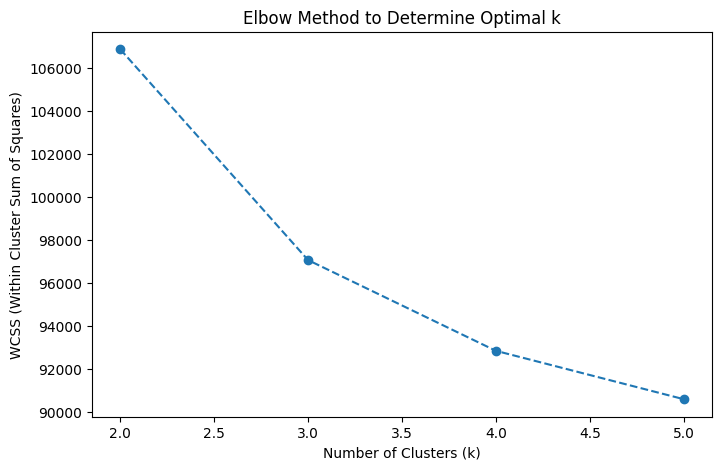

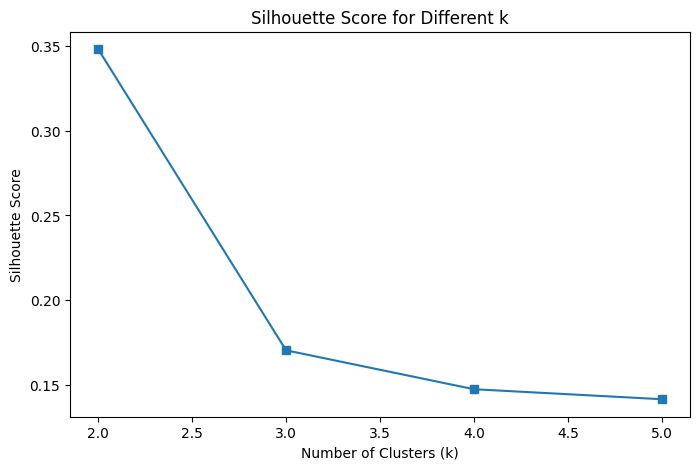

In [8]:
wcss = []
silhouette_scores = []
K_range = range(2, 6)  # Test k from 2 to 5

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within Cluster Sum of Squares)")
plt.title("Elbow Method to Determine Optimal k")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k")
plt.show()


Cluster_Label
0    34457
2    15327
1     1956
Name: count, dtype: int64


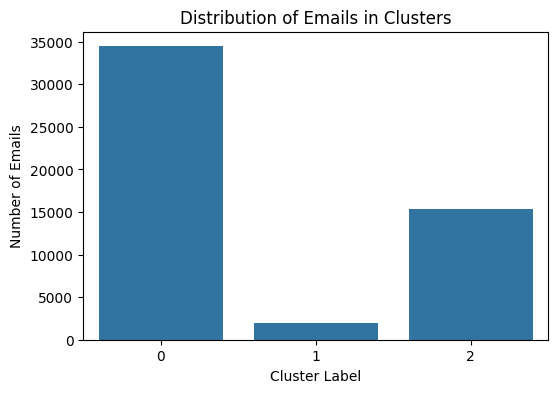

In [ ]:
optimal_k = 3  # Adjust based on elbow & silhouette method results

# Train k-Means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster_Label"] = kmeans.fit_predict(X)

# Display Cluster Distribution
print(df["Cluster_Label"].value_counts())

# Visualise Cluster Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df["Cluster_Label"])
plt.xlabel("Cluster Label")
plt.ylabel("Number of Emails")
plt.title("Distribution of Emails in Clusters")
plt.show()


Spam Classification Distribution:
 Spam_Label
0    49384
1     2356
Name: count, dtype: int64


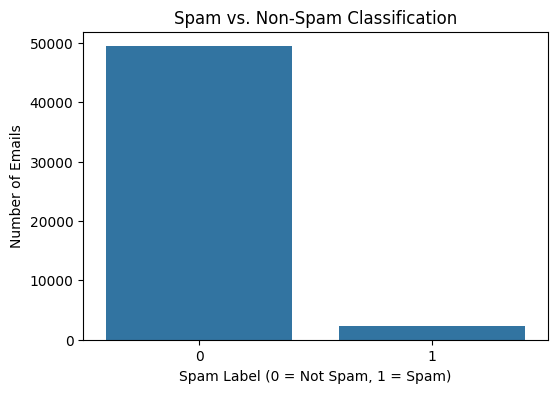


Sample Spam Emails:


,Processed_Subject,Processed_Body,Spam_Words_Subject,Spam_Words_Body,Is_External_Sender
21610,outback steakhouse read this it s a deal,original message from missy moriarty m_l_mauch...,0,2,1
25446,between the lines,between the lines issue november biweekly news...,0,4,1
24825,rfp service,image click click click image image image imag...,0,4,1
19751,gifts for dad deals for you,image image dear amazon customer as someone wh...,0,3,1
2016,fwd remember to vote,hey guz how s it going i hear you took that jo...,0,3,1
15084,investing basics gathering company information,______________________________________________...,0,5,1
22664,haikus for jews,jewish haiku it is common knowledge that poetr...,0,2,1
35138,february crisis and opportunity update,crisis and opportunity power markets march ala...,0,2,1
49008,the negotiation skills company inc newsletter aug,fighting fires without burning bridges sm the ...,0,2,1
11425,true orange e mail fax,forwarded by david m gagliardi ttg houind on a...,0,4,1



Sample Non-Spam Emails:


,Processed_Subject,Processed_Body,Spam_Words_Subject,Spam_Words_Body,Is_External_Sender
17259,an apology,please respond to i have done a crappy job of ...,0,0,1
14438,planned power outage at wtc on sunday february,there should be no impact but be prepared noti...,0,0,0
45700,midway toll term sheet loi comments,fred based on what dave says below we should t...,0,0,0
34939,ena and hpl transport contracts needed at mete...,yes you can create the deal ticket d aimee lan...,0,0,0
35250,question cheryl nelson,i am in the process of ordering more business ...,0,0,0
44214,richard babin retirement,after years with enron richard has decided to ...,0,0,0
37003,demand ken lay donate proceeds from enron stoc...,diego baz e duarte rd san gabriel ca diego_baz...,0,1,1
19731,announcing energy profit optimization seminar ...,for immediate release pros revenue management ...,0,1,1
42154,turbine purchase letter agreement,how does wednesday look for a conference call kay,0,0,0
18650,great basic documents,original message from nord sue sent friday aug...,0,0,0


In [ ]:
# Convert clusters into binary spam classification
df["Spam_Label"] = df.apply(lambda row: 1 if (row["Spam_Words_Body"] > 1 or row["Spam_Words_Subject"] > 1) and row["Is_External_Sender"] == 1 else 0, axis=1)

# Count the number of spam and non-spam emails
spam_counts = df["Spam_Label"].value_counts()
print("Spam Classification Distribution:\n", spam_counts)

# Visualising Spam vs. Non-Spam Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Spam_Label"])
plt.xlabel("Spam Label (0 = Not Spam, 1 = Spam)")
plt.ylabel("Number of Emails")
plt.title("Spam vs. Non-Spam Classification")
plt.show()

# Display samples of spam and non-spam emails
print("\nSample Spam Emails:")
display(df[df["Spam_Label"] == 1][["Processed_Subject", "Processed_Body", "Spam_Words_Subject", "Spam_Words_Body", "Is_External_Sender"]].sample(10))

print("\nSample Non-Spam Emails:")
display(df[df["Spam_Label"] == 0][["Processed_Subject", "Processed_Body", "Spam_Words_Subject", "Spam_Words_Body", "Is_External_Sender"]].sample(10))


In [ ]:

# Analyse each cluster after spam classification
for cluster in range(optimal_k):
    cluster_df = df[df["Cluster_Label"] == cluster]
    print(f"\nCluster {cluster} Analysis:")
    print(f"Total Emails in Cluster {cluster}: {len(cluster_df)}")
    print(f"Average Spam Words in Subject: {cluster_df['Spam_Words_Subject'].mean():.2f}")
    print(f"Average Spam Words in Body: {cluster_df['Spam_Words_Body'].mean():.2f}")
    print(f"External Emails (%): {100 * cluster_df['Is_External_Sender'].mean():.2f}%\n")



Cluster 0 Analysis:
Total Emails in Cluster 0: 34457
Average Spam Words in Subject: 0.00
Average Spam Words in Body: 0.00
External Emails (%): 12.30%


Cluster 1 Analysis:
Total Emails in Cluster 1: 1956
Average Spam Words in Subject: 0.11
Average Spam Words in Body: 3.65
External Emails (%): 60.02%


Cluster 2 Analysis:
Total Emails in Cluster 2: 15327
Average Spam Words in Subject: 0.04
Average Spam Words in Body: 1.23
External Emails (%): 24.17%



In [11]:
for cluster in range(optimal_k):
    cluster_df = df[df["Cluster_Label"] == cluster]

    # Display Cluster Statistics
    print(f"\n🔍 Cluster {cluster} Analysis:")
    print(f"📌 Total Emails in Cluster {cluster}: {len(cluster_df)}")
    print(f"✉️  Average Spam Words in Subject: {cluster_df['Spam_Words_Subject'].mean():.2f}")
    print(f"📩 Average Spam Words in Body: {cluster_df['Spam_Words_Body'].mean():.2f}")
    print(f"📧 External Emails (%): {100 * cluster_df['Is_External_Sender'].mean():.2f}%\n")

    # Display Sample Emails from Each Cluster
    display(cluster_df[["Processed_Subject", "Processed_Body", "Spam_Words_Subject", "Spam_Words_Body", "Is_External_Sender"]].sample(20))



🔍 Cluster 0 Analysis:
📌 Total Emails in Cluster 0: 34457
✉️  Average Spam Words in Subject: 0.00
📩 Average Spam Words in Body: 0.00
📧 External Emails (%): 12.30%



,Processed_Subject,Processed_Body,Spam_Words_Subject,Spam_Words_Body,Is_External_Sender
11527,enron hpl actuals for september,september teco tap enron hpl iferc ls hpl lsk ...,0,0,1
23484,constellation energy group employees give reco...,constellation energy group inc has added a new...,0,0,1
19727,legal risk memo for ceg ceg rio,mark this is a draft of the ceg ceg rio legal ...,0,0,0
10184,important stack manager users,we are in the process of confirming that all t...,0,0,0
47574,utc sales call,at utc s request yesterday mike jackson and i ...,0,0,0
23060,ees ca schedule for,the attached schedule is for wednesday jan ass...,0,0,0
39891,summary spreadsheet for data vendor research a...,hi fyi here is an updated spreadsheet summariz...,0,0,0
18394,energy opportunities,mike i represent a firm which has specialized ...,0,0,1
20998,vacation,k here is a list of the dates that i would lik...,0,0,0
36794,wharton collaborative research,forwarded by vince j kaminski hou ect on pm va...,0,0,0



🔍 Cluster 1 Analysis:
📌 Total Emails in Cluster 1: 1956
✉️  Average Spam Words in Subject: 0.11
📩 Average Spam Words in Body: 3.65
📧 External Emails (%): 60.02%



,Processed_Subject,Processed_Body,Spam_Words_Subject,Spam_Words_Body,Is_External_Sender
28616,rto week summary of standards and practices panel,original message from nicolay christi l sent m...,0,4,0
1448,neil anderson devotional for thursday january,if you are looking to feed and challenge your ...,0,4,1
48811,enerfax daily s free web version of gas power ...,subject click and go to http www enerfax com i...,1,3,1
18664,news clip,bna environment reporter oil ethanol industrie...,0,3,0
15593,real deals from travelocity com,dear larry when was the last time you got a we...,0,5,1
50105,enron in action,painters needed for the day of caring on septe...,0,3,0
33961,holiday raffle in enron lobby,hello we are the elves in black and we are hav...,0,3,0
37861,free burt s bees stocking stuffer plus up to o...,image nci marketing web alert click here for f...,1,4,1
51229,jonesnews jones news and information from the ...,original message from jonesnews jones school n...,0,3,0
16438,enron metals update,in my summer update about the acquisition of m...,0,3,0



🔍 Cluster 2 Analysis:
📌 Total Emails in Cluster 2: 15327
✉️  Average Spam Words in Subject: 0.04
📩 Average Spam Words in Body: 1.23
📧 External Emails (%): 24.17%



,Processed_Subject,Processed_Body,Spam_Words_Subject,Spam_Words_Body,Is_External_Sender
30167,southwest gas discount amendment changes,i m ok with the new version thanks df forwarde...,0,1,0
6898,ge release,this language is different that what ge was to...,0,1,0
7575,test,molly fyi vince forwarded by vince j kaminski ...,0,1,0
33230,e case,here is what i have put together so far i just...,0,2,1
2766,message to be sent,debbie let me know if you get this cindy origi...,0,1,0
24352,calpine offpeak firm confirmation,this change is acceptable melissa will you be ...,0,1,0
36985,quaker oats frito lay starwood dash reviews,scott to follow up from a bunch of earlier dis...,0,2,0
4547,concur expense document may,the approval status has changed on the followi...,0,1,0
24243,many,forwarded by vince j kaminski hou ect on pm ge...,0,1,0
22438,summary rto week day planning expansion,original message from nicolay christi l sent m...,0,1,0
